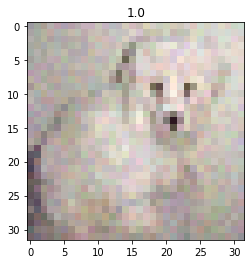

In [ ]:
plt.imshow(x_train[2])
plt.title(y_train[2])
plt.show()

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

with np.load('prediction-challenge-02-data.npz') as fh:
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

# TEST DATA: INPUT (x) ONLY
print(x_test.shape, x_test.dtype)

(3000, 32, 32, 3) float32
(3000,) float64
(300, 32, 32, 3) float32


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# seed = 0
# random.seed(seed)
# torch.manual_seed(seed)

In [ ]:
X = torch.from_numpy(x_train).to(device).transpose(1,3)
Y = torch.from_numpy(y_train).to(device)
test = torch.from_numpy(x_test).to(device).transpose(1,3)

In [ ]:
X.to(device).dtype

torch.float32

# Convolutional Neural Network
Well known and inspired by visual cortex; Receptive Fields.

ILSVRC 2015 - 20 times * AlexNet. Increasing depth, Better feature representations. However, increases complexity.

Why choose CNN ?
-	What are the benefits over others
-	CNN - Basic Structure and significance
-	Weight Sharing, Receptive Field and Translational Equivariance

a DNN, 
-	Full connectivity between nodes cause the curse of dimensionality
-	Does not take into account the spatial structure of data 

Basic CNN Components:
consists of three types of layers - convolutional, pooling, and fully-connected layers

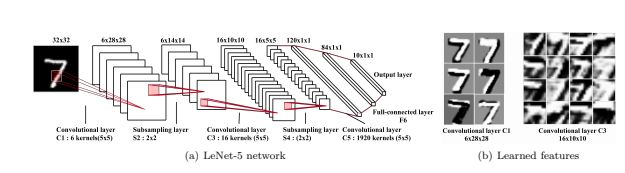


Convolutional Layer 
-	Aims to learn feature representations of the input
-	Several kernels/filters to compute different feature maps (3-D Volume Tensors)
-	Neuron’s Receptive field i.e.each neuron is connected to only a small region of the layer before
-	Weight sharing: to generate feature map, kernel is shared by all spatial locations of the input
-	Activation function (sigmoid, tanh and ReLU) used to detect nonlinear features
-	Overfitting and Regularization: Weight Initialization, p-norm, Dropout


Kernels : Tensor defined by (number of inputs) x (input height) x (input width) x (input channels). After convolutional operation, the image becomes abstracted to a feature map. Additional hyperparameters of the convolution operation, such as: padding, stride, and dilation


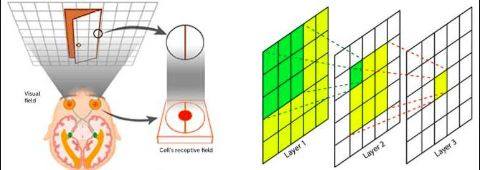

**Receptive Field** 

In a convolutional layer, each neuron of a feature map is connected to a region of neighbouring neurons in the previous layer. Referred to as the neuron’s receptive field.

Stacking many such convolution layers allows for spatial locality - by enforcing a local connectivity pattern between neurons of adjacent layers.

Thus, CNN architecture ensures that the learned "filters" produce the strongest response to a spatially local input pattern. That is, it becomes increasingly global (i.e. responsive to a larger region of pixel space) so that the network first creates representations of small parts of the input, then from them assembles representations of larger areas.




**Weight Sharing**

In CNNs, each filter is replicated across the entire visual field.This means that all the neurons in a given convolutional layer respond to the same feature within their specific response field. 

Reduces the number of free parameters learned, reduce the model complexity and make the network easier to train. 

Replicating units in this way allows for the resulting feature map to be equivariant under shifts of the locations of input features in the visual field, i.e. they grant translational equivariance - given that the layer has a stride of one. 

Pooling Layers

-	Reduce the dimensions of data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer
-	Aims to achieve shift-invariance by reducing the resolution of the feature maps 
-	The typical pooling operations are average pooling and max pooling 

Fully connected layers 

- Aims to perform high-level reasoning

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv_layer = nn.Sequential(
        # Conv Layer block 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv Layer block 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.05),

        # Conv Layer block 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )


    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 3)
    )

  def forward(self, x):
    # conv layers
    x = self.conv_layer(x)
        
    # flatten
    x = x.view(x.size(0), -1)
        
    # fc layer
    x = self.fc_layer(x)

    return x

**Cross Entropy Loss** 

Cross Entropy is the average number of bits needed to compress data from some underlying distribution p using a code for an approximation of the target distribution q

In general, cross entropy is not the same as relative entropy (KL divergence), where the latter only gives the number of extra bits required to represent information with q instead of p.

However, they both calculate the same quantitiy when used as loss functions for classification. 


**Adam**



*   Adaptive learning rate method
*   Power of SDG and RMSprop (to handle sparse gradients and non-convex optimization)
*   Relies on running exponential moving averages of first and second moments, but also some bias correction to keep the earlier contributions significant 









In [ ]:
def train(model, X, Y, test_x, test_y, n_epochs, batch_size, learning_rate, lambda_l2):

    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task




    criterion = torch.nn.CrossEntropyLoss()
    # criterion = torch.nn.NLLLoss()
    losses = []
    accs = []
    test_losses = []
    test_accs = []
    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2


    # Training
    for t in range(n_epochs):
        permutation = torch.randperm(X.size()[0])

        for i in range(0,X.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]

            # in case you wanted a semi-full example
            y_pred = model.forward(batch_x)

            loss = criterion(y_pred.to(torch.double), batch_y.to(torch.long))
            score, predicted = torch.max(y_pred, 1)
            acc = (batch_y == predicted).sum().float() / len(batch_y)
            

            # zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()

            # Update params
            optimizer.step()

            losses.append(loss.item())
            accs.append(acc.cpu().detach().numpy())
        # if ((t%5) == 0):
        #     print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
            batch = i/batch_size
            batches = X.size()[0]/batch_size
            sys.stdout.write(f'\rEpoch: {t}/{n_epochs} Step: {batch}/{batches} Loss: {loss.item():.6f} Acc: {acc:.2%}' )

        model.eval()

        test_output = model(test_x)
        test_loss = criterion(test_output.to(torch.double), test_y.to(torch.long))

        test_yhat = torch.argmax(test_output, dim=1)
        test_acc = torch.sum(test_yhat == test_y) / float(len(test_y)) 

        test_losses.append(test_loss.item())
        test_accs.append(test_acc.cpu().detach().numpy())
        model.train()

        sys.stdout.write(f'\rEpoch: {t}/{n_epochs} Step: {"-"}/{"-"} Loss: {"-"} Acc: {"-"} Test loss: {test_loss.item():.6f} test acc: {test_acc:.2%}' )
      
    return losses, accs, test_losses, test_accs


In [ ]:
def grid_search(num_epochs, batch_size, learning_rate, lambda_l2 = 1e-5):
  from sklearn.model_selection import StratifiedKFold
  skf = StratifiedKFold(n_splits=5)
  skf.get_n_splits(X, Y)
  predictions = []
  kfold_accuracy = []
  losses = []
  accs = []
  test_losses = []
  test_accs = []

  def reset_model(model):
      for layer in model.children():
          if hasattr(layer, 'reset_parameters'):
              layer.reset_parameters()
      return model


  old_index = None
  for i, (train_index, test_index) in enumerate(skf.split(X.cpu(), Y.cpu())):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      model = Net()
      model.to(device)
      model = reset_model(model)
      model.train()
      fold_loss, fold_acc, test_loss, test_acc = train(model, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate, lambda_l2)
      losses.append(fold_loss)
      accs.append(fold_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)
      
      with torch.no_grad():
          model.eval()
          
          y_pred = model(X_test)
          _, predicted = torch.max(y_pred, 1)
          # print(predicted)
          
          acc = (y_test == predicted).sum().float() / len(y_test)
          kfold_accuracy.append(acc.cpu().detach().numpy())
          # print("[SPLIT]: %i, [ACCURACY]: %.3f" % (i, acc))
          outputs = model(test)
      _, predicted = torch.max(outputs, 1)

      predictions.append(predicted.cpu().detach().numpy())
  return predictions, np.asarray(kfold_accuracy).mean(), losses, accs, test_losses, test_accs
  

In [ ]:
# best_param = None
# best_predictions = None
# max_accuracy = 0
# i = 0
# for num_epochs in range(0, 30, 5):
#   for lr in [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3]:
#     for batch_size in [16, 32, 64, 128]:
#       predictions, kf = grid_search(num_epochs = num_epochs, batch_size = batch_size, learning_rate = lr)
#       if kf >= max_accuracy:
#         best_param = [num_epochs, lr, batch_size]
#         max_accuracy = kf
#         best_predictions = predictions
#         print(max_accuracy, best_param, i)

#       i += 1

In [ ]:
predictions, accuracy, losses, accs, test_loss, test_acc = grid_search(num_epochs = 30, batch_size = 64, learning_rate = 0.001)

Epoch: 29/30 Step: -/- Loss: - Acc: - Test loss: 1.284087 test acc: 65.33%

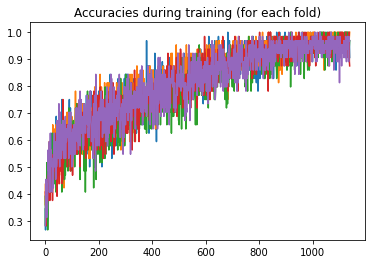

In [ ]:
import matplotlib.pyplot as plt
for item in accs:
  plt.title("Accuracies during training (for each fold)")
  plt.plot(item)

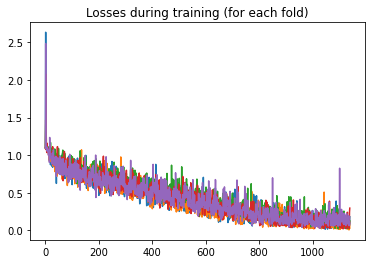

In [ ]:
for item in losses:
  plt.title("Losses during training (for each fold)")
  plt.plot(item)

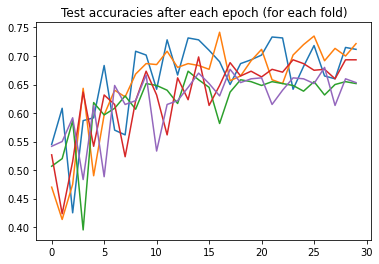

In [ ]:
for item in test_acc:
  plt.title("Test accuracies after each epoch (for each fold)")
  plt.plot(item)

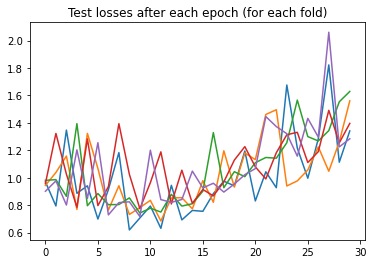

In [ ]:
for item in test_loss:
  plt.title("Test losses after each epoch (for each fold)")
  plt.plot(item)

In [ ]:
predictions = np.asarray(predictions)
from scipy import stats
prediction, counts = stats.mode(predictions)

prediction = prediction.squeeze()

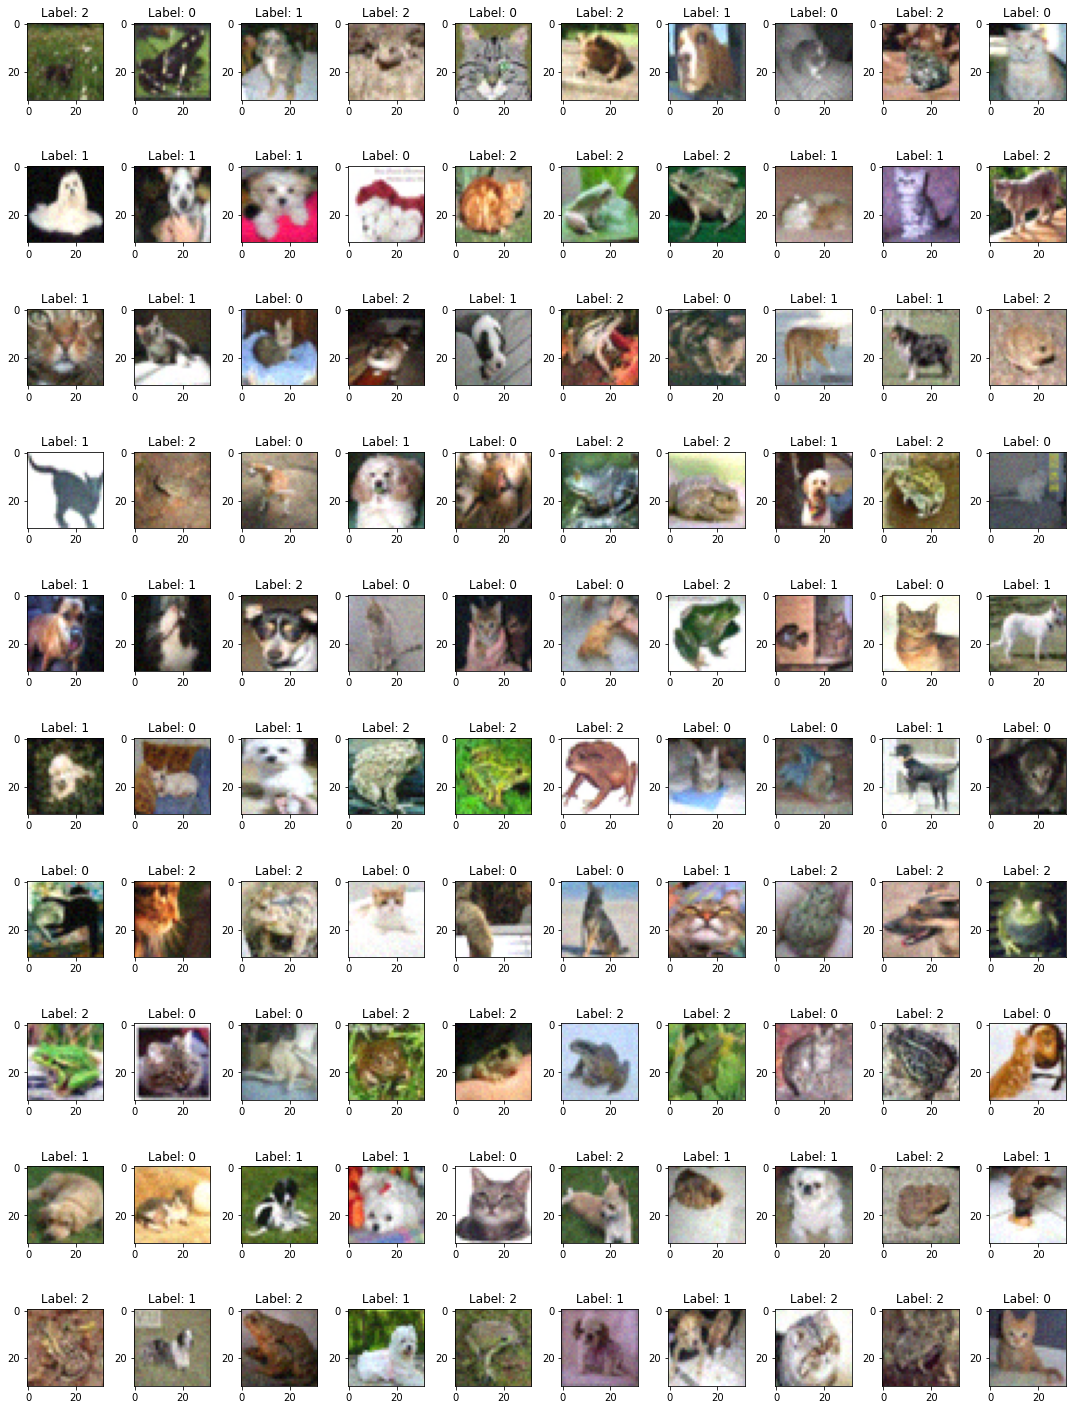

In [ ]:
num = 100

num_row = 10
num_col = 10# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_test[i].reshape(32,32, 3), cmap='gray')
    ax.set_title('Label: {}'.format(prediction[i]))
plt.tight_layout()
plt.show()

In [ ]:
print(prediction.shape)
print("Accuracy: {}".format(accuracy))
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('predictionn.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
validate_prediction_format()

(300,)
Accuracy: 0.9096667170524597
